# Utils

### Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import nibabel as nib
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

In [ ]:
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Paths and folders

In [ ]:
# FC maps mean
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/'
dir_FCmaps3D_processed = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps3D_processed/'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/mask_GM.nii'
atrophy_dataset_matches = './data_utils/atrophy_matched.xlsx'
labels_csv = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils'

In [ ]:
# Create output directory if it doesn't exist
os.makedirs(dir_FCmaps3D_processed, exist_ok=True)

### Functions

In [ ]:
def evaluate_metrics(y_true, y_pred):
    """
    Calculate the evaluation metrics: MSE, RMSE, MAE, and R².
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Data

### Load data

#### Functional Connectivity maps

Load the FC maps data in nii.gz format and extract the subjects identifiers

In [ ]:
# Path to FC maps
files = sorted(glob.glob(os.path.join(dir_FCmaps, '*gz')))

# Extract Subject IDs from filenames
sub_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files]

In [ ]:
print("Check lunghezza:")
print("Files: ", len(files))
print("Soggetti: ", len(sub_id))

One file example

In [ ]:
path_temp = os.path.join(dir_FCmaps, '1_S_5005.FDC.nii.gz')
temp = nib.load(path_temp).get_fdata()

In [ ]:
temp.shape



Flatten and store each subject’s data (the FC maps)

In [ ]:
# Loop over files and add the brain maps
maps_FDC=[]
for x in range(len(files)):
    print(files[x])
    d=nib.load(files[x]).get_fdata().flatten()
    maps_FDC.append(d)

# Stores subjects as rows and voxels as columns + subjects id
df=pd.DataFrame(maps_FDC)
df.insert(0, 'ID', sub_id)

In [ ]:
print("\n", df.shape, "\n")
df.iloc[:5, :5]

### Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [ ]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(atrophy_dataset_matches, sheet_name='dataset')
df_meta['Age'] = df_meta['Age'].round(1)

In [ ]:
df_meta.head(5)

In [ ]:
# Picking the columns we need
meta_columns = ['ID', 'Group', 'CDR', 'CDR_SB', 'Age']
df_labels = df_meta[meta_columns]
df_labels = df_labels.set_index('ID').loc[df['ID']].reset_index()

#### EDA on Labels

In [ ]:
print("CONTROLS")
print("Excel: ",df_meta.shape)
print("Labels: ", df_labels.shape)
assert all(df_labels['ID'] == df['ID']), "Mismatch tra ID di df e df_labels"

In [ ]:
# General info
print(df_labels.info())

In [ ]:
# Missing values
print("\nMissing values for column:")
print(df_labels.isna().sum())

In [381]:
# Unique values
print("\nUnique Values:")
print("Group:", sorted(df_labels['Group'].unique()))  # Ordinamento alfabetico
print("CDR:", np.sort(df_labels['CDR'].unique()))
print("CDR_SB:", np.sort(df_labels['CDR_SB'].unique()))


Unique Values:
Group: ['ADNI', 'CBS', 'PSP']
CDR: [0.  0.5 1.  2.  3. ]
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18. ]


Substitute the NaN with 0

In [ ]:
df_labels['CDR'] = pd.to_numeric(df_labels['CDR'], errors='coerce').fillna(0)
df_labels['CDR_SB'] = pd.to_numeric(df_labels['CDR_SB'], errors='coerce').fillna(0)

In [ ]:
print("Missing values:")
print(df_labels.isna().sum())

In [ ]:
print(df_labels.select_dtypes(include='number').describe().round(1))

In [ ]:
print("How many zero values in CDR_SB:", (df_labels['CDR_SB']== 0).sum())
print("How many zero values in CDR:", (df_labels['CDR']== 0).sum())

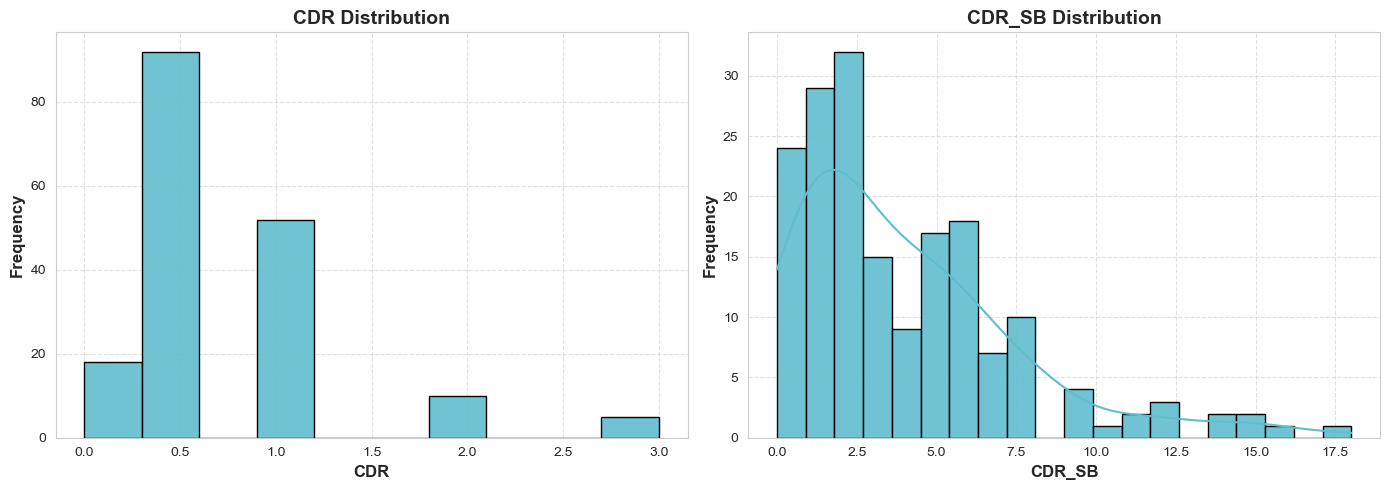

In [382]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CDR histogram
sns.histplot(df_labels['CDR'], bins=10, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.9)
axes[0].set_title("CDR Distribution", fontsize=14, weight='bold')
axes[0].set_xlabel("CDR", fontsize=12, weight='bold')
axes[0].set_ylabel("Frequency", fontsize=12, weight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)

# CDR_SB histogram + KDE
sns.histplot(df_labels['CDR_SB'], bins=20, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.9, kde=True)
axes[1].set_title("CDR_SB Distribution", fontsize=14, weight='bold')
axes[1].set_xlabel("CDR_SB", fontsize=12, weight='bold')
axes[1].set_ylabel("Frequency", fontsize=12, weight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

#### CSV labels

Creating a new CSV with the labels columns we need for the various analysis and the right order


In [ ]:
df_labels.to_csv(os.path.join(dir_data_utils, 'labels.csv'), index=False)

### Preprocessing

#### Thresholding

Set a threshold for values below 0.2 for defining correlation

In [352]:
def apply_threshold(df, threshold):
    df_thr = df.copy()
    df_thr.iloc[:, 1:] = df_thr.iloc[:, 1:].mask(df_thr.iloc[:, 1:] < threshold, 0)
    return df_thr

In [ ]:
df_thr_01 = apply_threshold(df, threshold=0.1)

In [354]:
df_thr_02 = apply_threshold(df, threshold=0.2)

#### GM Mask

- Binary mask of grey matter using the Harvard-Oxford Atlas

- Keeping the Gray Matter voxels

In [ ]:
def apply_mask(df_thr, mask_path):
    # Load and flatten GM mask
    mask = nib.load(mask_path).get_fdata().flatten()
    assert mask.shape[0] == df_thr.shape[1] - 1, "Mask and data length mismatch"

    # Mask
    voxel_data = df_thr.iloc[:, 1:]
    voxel_data_masked = voxel_data.loc[:, mask != 0]

    # Return the masked dataframe
    df_masked = pd.concat([df_thr[['ID']], voxel_data_masked], axis=1)
    df_masked.columns = ['ID'] + list(range(voxel_data_masked.shape[1]))
    return df_masked

In [355]:
df_thr01_gm_masked = apply_mask(df_thr_01, gm_mask_path)
print(df_thr01_gm_masked.shape)

df_thr02_gm_masked = apply_mask(df_thr_02, gm_mask_path)
print(df_thr02_gm_masked.shape)

(177, 161818)
(177, 161818)


In [ ]:
df_thr01_har_masked = apply_mask(df_thr_01, harvard_oxford_mask_path)
print(df_thr01_har_masked.shape)

df_thr02_har_masked = apply_mask(df_thr_02, harvard_oxford_mask_path)
print(df_thr02_har_masked.shape)

#### Checking

In [ ]:
def check_voxel_data(df_masked, threshold):
    print(f"Shape: {df_masked.shape}")

    # Check thresholding
    has_low = ((df_masked.iloc[:, 1:] > 0) & (df_masked.iloc[:, 1:] < threshold)).any().any()
    print("Valori tra 0 e 0.2:", has_low)

    # Check 0 maps
    zero_rows = (df_masked.iloc[:, 1:] == 0).all(axis=1).sum()
    print(f"Mappe completamente a 0: {zero_rows} su {df_masked.shape[0]}")

    #Statistics
    voxel_data = df_masked.iloc[:, 1:].values
    nonzero_voxels = voxel_data[voxel_data != 0]

    print("\nAll voxel:")
    print(f"Min: {voxel_data.min():.4f}")
    print(f"Max: {voxel_data.max():.4f}")
    print(f"Mean: {voxel_data.mean():.4f}")
    print(f"Std: {voxel_data.std():.4f}")

    print("\nVoxel ≠ 0:")
    print(f"Min: {nonzero_voxels.min():.4f}")
    print(f"Max: {nonzero_voxels.max():.4f}")
    print(f"Mean: {nonzero_voxels.mean():.4f}")
    print(f"Std: {nonzero_voxels.std():.4f}")

In [ ]:
check_voxel_data(df_thr02_gm_masked, 0.2)

# Analysis with UMAP

### Input Data

For the further analysis we will remove the ID labels columns, but the order is mantained.

Possible dataset:
- df_thr01_gm_masked
- df_thr02_gm_masked
- df_thr01_har_masked
- df_thr02_har_masked

In [356]:
def x_features_return(df_features, dataframe_labels, cols):
    # Merge based on subject ID
    dataframe_merge = pd.merge(df_features, dataframe_labels, on='ID', how='left')

    # Reorder columns: metadata first, then voxel features
    ordered_cols = cols + [col for col in dataframe_merge.columns if col not in cols]
    dataframe_merge = dataframe_merge[ordered_cols]

    # Sanity check to ensure row alignment
    assert all(dataframe_merge['ID'] == df_features['ID']), "Row order mismatch after merge"

    # Extract features only (drop metadata)
    x = dataframe_merge.drop(columns=cols)
    return dataframe_merge, x

In [359]:
df_merged, X = x_features_return(df_thr02_gm_masked, df_labels, meta_columns)

In [360]:
X.shape

(177, 161817)

### Unsupervised Clustering

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [ ]:
def run_umap(x_input, plot_flag =True):
   # Parameters
    reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', n_epochs=1000, learning_rate=1.0, init='spectral', min_dist=0.1, spread=1.0, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=1, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, random_state=42, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, transform_seed=42, verbose=False, unique=False)

    # Reduce dimensionality
    x_umap = reducer.fit_transform(x_input)

    # Plot
    if plot_flag:
        plt.figure(figsize=(8, 6))
        plt.scatter(x_umap[:, 0], x_umap[:, 1], s=10, alpha=0.6)
        plt.title("UMAP Embedding")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.grid(True)
        plt.show()

    return x_umap

In [ ]:
X_umap = run_umap(X, True)

Unsupervised clustering

In [ ]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# DBSCAN
clusterer_db = DBSCAN(eps=0.5, min_samples=5)
labels_db = clusterer_db.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_umap)

# Dataframe for collecting data
labeling_umap = pd.DataFrame({
    'labels_hdb': labels_hdb,  # HDBSCAN clusters
    'labels_db': labels_db,    # DBSCAN clusters
    'labels_km': labels_km,    # K-Means clusters
    'labels_gmm': labels_gmm,  # GMM clusters
    'X1': X_umap[:, 0],        # UMAP component 1
    'X2': X_umap[:, 1],        # UMAP component 2
    'group': df_merged['Group'],        # Diagnosis
    'subject_id': df_merged['ID']       # Identifiers
})

#### Plotting

In [ ]:
def plot_clusters_vs_groups(X_umap, labels_dict, group_column, figsize=(16, 24), margin=5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    n = len(labels_dict)
    n_cols = 2
    n_rows = n

    # Calcola limiti comuni per tutti i plot
    x_min, x_max = X_umap[:, 0].min() - margin, X_umap[:, 0].max() + margin
    y_min, y_max = X_umap[:, 1].min() - margin, X_umap[:, 1].max() + margin

    # Crea figura e assi
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Loop su ogni tecnica di clustering
    for i, (title, labels) in enumerate(labels_dict.items()):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        # DataFrame per plotting
        plot_df = pd.DataFrame({
            'X1': X_umap[:, 0],
            'X2': X_umap[:, 1],
            'cluster': labels,
            'group': group_column
        })

        # Clustering
        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='cluster', palette='Set1', s=50, ax=ax_left, legend='full')
        ax_left.set_title(f'{title} - Clustering')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_xlabel("UMAP 1")
        ax_left.set_ylabel("UMAP 2")

        # Group labeling
        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='group', palette='Set2', s=50, ax=ax_right, legend='full')
        ax_right.set_title(f'{title} - Group Labeling')
        ax_right.set_xlim(x_min, x_max)
        ax_right.set_ylim(y_min, y_max)
        ax_right.set_xlabel("UMAP 1")
        ax_right.set_ylabel("UMAP 2")

    plt.tight_layout()
    plt.show()

In [ ]:
# Dictionary of clustering results
labels_dict = {
    "HDBSCAN": labeling_umap['labels_hdb'],
    "DBSCAN": labeling_umap['labels_db'],
    "K-Means": labeling_umap['labels_km'],
    "GMM": labeling_umap['labels_gmm']
}

plot_clusters_vs_groups(X_umap, labels_dict, labeling_umap['group'])

## Regression

Input and target definition

In [391]:
# Features
df_merged, X = x_features_return(df_thr02_gm_masked, df_labels, meta_columns)

# Target variable
y = df_merged['CDR_SB']
y_log = np.log1p(y)

Reduction

In [392]:
X_umap = run_umap(X, False)

Fit  regressions model

In [393]:
def fit_ols_model(X, y):
    # Add a constant to the features
    X_ols = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X_ols).fit()

    # Predictions and residuals
    y_pred = model.predict(X_ols)
    residuals = y - y_pred


    return model, y_pred, residuals

In [411]:
def plot_ols_diagnostics(y, y_pred, residuals, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: True vs Predicted
    sns.scatterplot(x=y, y=y_pred, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.8, s=50)
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
    axes[0].set_title("True vs Predicted", fontsize=14, weight='bold')
    axes[0].set_xlabel("True CDR_SB", fontsize=12, weight='bold')
    axes[0].set_ylabel("Predicted CDR_SB", fontsize=12, weight='bold')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Residuals vs Predicted
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.8, s=50)
    axes[1].axhline(0, linestyle='--', color='gray')
    axes[1].set_title("Residuals vs Fitted", fontsize=14, weight='bold')
    axes[1].set_xlabel("Predicted CDR_SB", fontsize=12, weight='bold')
    axes[1].set_ylabel("Residuals", fontsize=12, weight='bold')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Titolo globale sopra i due plot
    fig.suptitle(title,fontsize=16, weight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

Without logistic normalization  of the target

In [395]:
model, y_pred, residuals = fit_ols_model(X_umap, y)
print(model.summary(),"\n")

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     6.137
Date:                Tue, 22 Apr 2025   Prob (F-statistic):            0.00266
Time:                        15:40:31   Log-Likelihood:                -466.32
No. Observations:                 177   AIC:                             938.6
Df Residuals:                     174   BIC:                             948.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2343      2.848      4.647      0.0

With logistic normalization  of the target

In [396]:
model_log, y_pred_log, residuals_log = fit_ols_model(X_umap, y_log)
print(model.summary(),"\n")

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     6.137
Date:                Tue, 22 Apr 2025   Prob (F-statistic):            0.00266
Time:                        15:40:33   Log-Likelihood:                -466.32
No. Observations:                 177   AIC:                             938.6
Df Residuals:                     174   BIC:                             948.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2343      2.848      4.647      0.0

In [397]:
print("MAE", mean_absolute_error(y, y_pred))
print("MAE", mean_absolute_error(y_log, y_pred_log),"\n")

MAE 2.6330150050264467
MAE 0.5599282768946225 



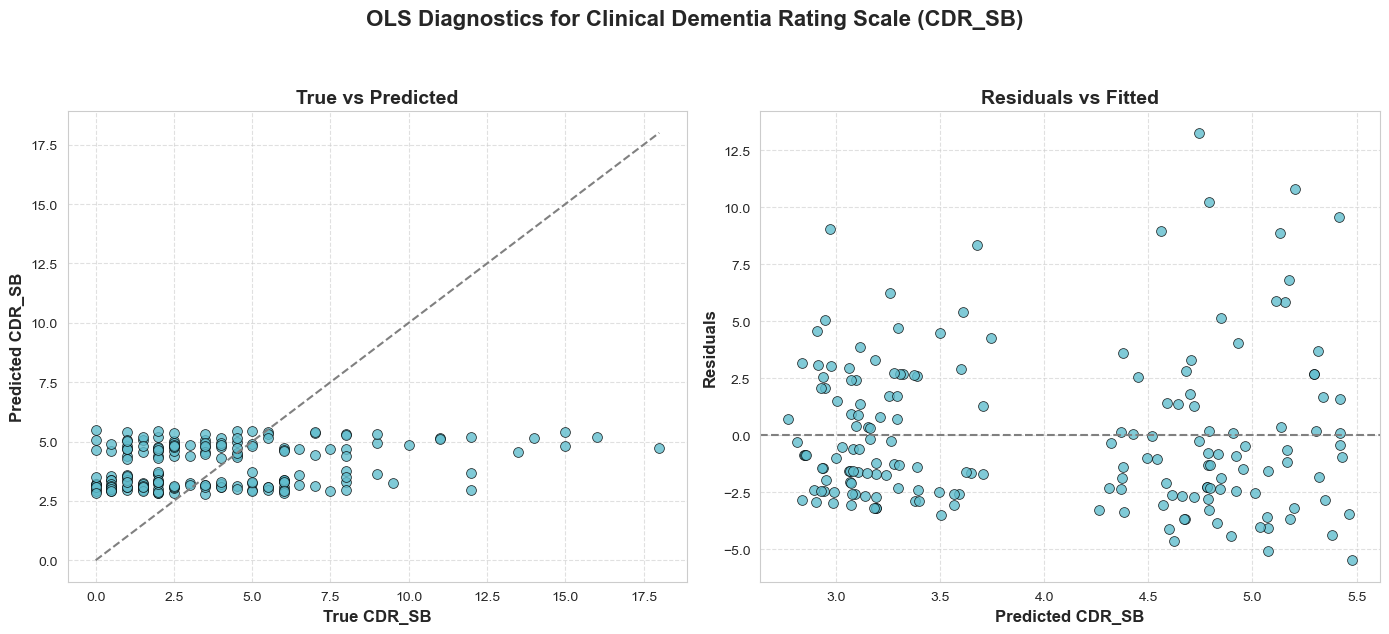

In [412]:
plot_ols_diagnostics(y, y_pred, residuals, "OLS Diagnostics for Clinical Dementia Rating Scale (CDR_SB)")

#### Analysis

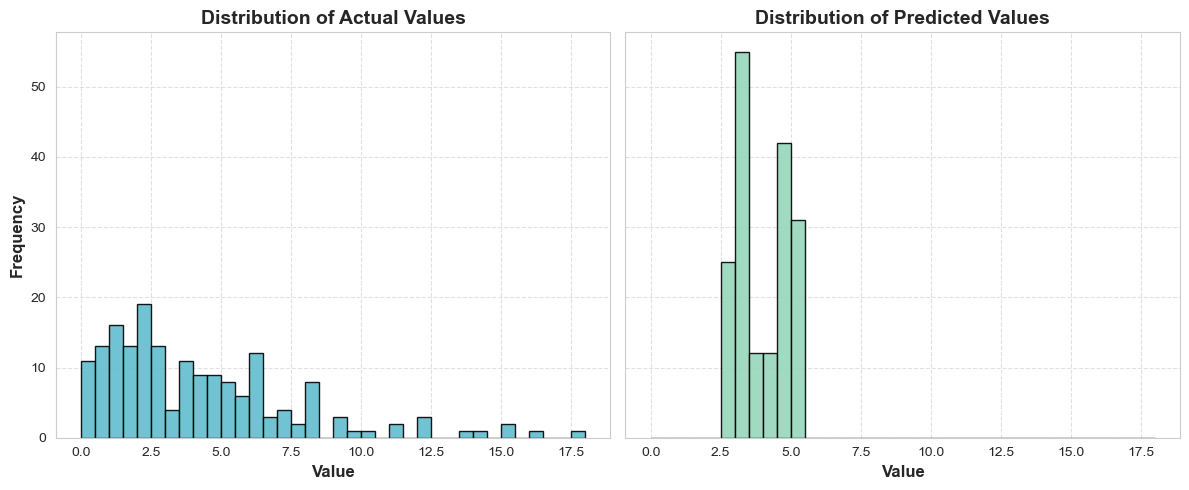

In [413]:
actual = y
pred = y_pred

# Binning
bins = np.arange(min(actual), max(actual) + 0.5, 0.5)

# Subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].hist(actual, bins=bins, color='#61bdcd', edgecolor='black', alpha=0.9)
axs[0].set_title('Distribution of Actual Values', fontsize=14, weight='bold')
axs[0].set_xlabel('Value', fontsize=12, weight='bold')
axs[0].set_ylabel('Frequency', fontsize=12, weight='bold')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].hist(pred, bins=bins, color='#95d6bb', edgecolor='black', alpha=0.9)
axs[1].set_title('Distribution of Predicted Values', fontsize=14, weight='bold')
axs[1].set_xlabel('Value', fontsize=12, weight='bold')
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [415]:
# Calcola errore assoluto soggetto per soggetto
residuals = y - y_pred
abs_errors = np.abs(residuals)

# Aggiungi errore assoluto al dataframe
df_merged['Absolute_Error'] = abs_errors

# Gruppo per gruppo: errore medio, std, N
group_errors = df_merged.groupby('Group')['Absolute_Error'].agg(
    Mean_Error='mean',
    Std_Error='std',
    N='count'
).round(2).sort_values('Mean_Error', ascending=False)

# Output
print("Errore assoluto medio per gruppo diagnostico:")
print(group_errors)

Errore assoluto medio per gruppo diagnostico:
       Mean_Error  Std_Error   N
Group                           
PSP          3.01       2.32  61
CBS          2.91       2.29  44
ADNI         2.14       1.71  72


# CNN Classification

## Preprocessing

In [ ]:
# Check subject ID and path alignment
for f, sid in zip(files, sub_id):
    assert sid in os.path.basename(f), f"ID mismatch: {sid} not in {f}"

Load the mask

In [ ]:
mask_3D = nib.load(gm_mask_path).get_fdata()
assert mask_3D.shape == temp.shape, "Mask shape does not match FC map shape"

The data have been loaded above. Now we will process the FC maps and save them in a 3D format:
- Loading

- Thresholding

- Masking

In [ ]:
for file_path, subj_id in zip(files, sub_id):
    # Load 3D FC map
    img = nib.load(file_path).get_fdata()

    # Apply threshold
    img[img < 0.2] = 0

    # Apply GM mask
    img[mask == 0] = 0

    # Save to .npy
    out_path = os.path.join(dir_FCmaps3D_processed, f"{subj_id}.npy")
    np.save(out_path, img)

    # TODO: normalization (?)

print("All maps processed and saved.")

## Further analysis

In [ ]:
files = glob.glob(os.path.join(dir_FCmaps3D_processed, '*.npy'))

In [ ]:
 np.load(files[0]).shape

In [ ]:
mins, maxs, means, stds = [], [], [], []
empty_count = 0

# Loop through each file and calculate statistics
for f in files:
    data = np.load(f)
    nonzero = data[data != 0]

    if nonzero.size > 0:
        mins.append(nonzero.min())
        maxs.append(nonzero.max())
        means.append(nonzero.mean())
        stds.append(nonzero.std())
    else:
        empty_count += 1
        print(f"All-zero map: {os.path.basename(f)}")

# Print summary
print("-----------------------------")
print(f"Voxel stats across {len(files) - empty_count} valid subjects:")
print(f"- Min:  {np.min(mins):.4f}  and  Max:  {np.max(maxs):.4f}")
print(f"- Mean: {np.mean(means):.4f} ")
print(f"- Std: {np.mean(stds):.4f}")

## Data Augmentation